## Required Imports and Helper functions taken from the coursera project

In [1]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import os
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
from pydub.playback import play
import librosa as lr

# Calculate and plot spectrogram for a wav audio file

# Load a wav file
def get_wav_info(wav_file):
    data, rate = lr.load(path=wav_file,sr=44100)
    return rate, data

# Used to standardize volume of audio clip
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

# Load raw audio files for speech synthesis
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft =  200#of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins,im= plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins,im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx,freqs,bins

def load_raw_audio():
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("positives"):
        if filename.endswith("wav"):
            positive = AudioSegment.from_wav("positives/"+filename)
            positives.append(positive)
    for filename in os.listdir("backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("negatives/"+filename)
            negatives.append(negative)
    return positives,negatives, backgrounds

/data/anaconda/envs/py35/lib/python3.5/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/data/anaconda/envs/py35/lib/python3.5/site-packages/pydub/utils.py:179: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


In [2]:
import IPython.display as ipd
#ipd.Audio("positives/1.wav")
#ipd.Audio("negatives/1.wav")
#ipd.Audio("backgrounds_before_processing/white_noise.wav")

### Converting the background noises to 10s clips

In [3]:
ac_noise=AudioSegment.from_wav("backgrounds_before_processing/ac_noise.wav")

In [4]:
time=10*1000
ac_noise_clipped=ac_noise[:time]

In [5]:
ac_noise_clipped.export("backgrounds/ac_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/ac_noise_clipped.wav'>

In [6]:
pink_noise=AudioSegment.from_wav("backgrounds_before_processing/pink_noise.wav")

In [7]:
pink_noise_clipped=pink_noise[:time]

In [8]:
pink_noise_clipped.export("backgrounds/pink_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/pink_noise_clipped.wav'>

In [9]:
white_noise=AudioSegment.from_wav("backgrounds_before_processing/white_noise.wav")

In [10]:
white_noise_clipped=white_noise[:time]

In [11]:
white_noise_clipped.export("backgrounds_before_processing/white_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds_before_processing/white_noise_clipped.wav'>

In [12]:
doing_the_dishes_noise=AudioSegment.from_wav("backgrounds_before_processing/doing_the_dishes_noise.wav")

In [13]:
doing_the_dishes_noise_clipped=doing_the_dishes_noise[:time]

In [14]:
doing_the_dishes_noise_clipped.export("backgrounds/doing_the_dishes_noise_clipped.wav",format="wav")

<_io.BufferedRandom name='backgrounds/doing_the_dishes_noise_clipped.wav'>

# The original sampling rates for the noises are:
ac_noise=> 48000
doing_the_dishes_noise=>16000
pink_noise=>16000
white_noise=>16000

In [15]:
rate,audio=get_wav_info("backgrounds_before_processing/white_noise.wav")

In [16]:
rate,audio.shape

(44100, (2646000,))

there is a small confusion! the audio part of the ac_noise read using wavfile.read from scipy gives a two dimensional array but if its read using librosa that problem is done, still the no of samples in the ac_noise and ac_noise_clipped is different

In [17]:
rate,audio=get_wav_info("backgrounds_before_processing/ac_noise.wav")

In [18]:
audio.shape,rate

((572948,), 44100)

###          







### Checking if the clipping is proper and analysing various rates and audio files

In [19]:
rate1,audio1=get_wav_info("negatives/1.wav")

In [20]:
print(rate1,audio1.shape)

44100 (44100,)


## Now all the audio files are ready to be used, you can get the rate and the audio array by just calling the function get_wav_info

In [21]:
rate3,audio3=get_wav_info("positives/2.wav")

In [22]:
print(rate3,audio3.shape)

44100 (20479,)


(101, 254)
(101,)
(254,)


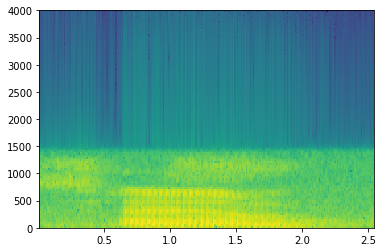

In [23]:
f,g,h=graph_spectrogram("positives/2.wav")
print(f.shape)
print(g.shape)
print(h.shape)


# Starting to build the training dataset

In [24]:
#activates, negatives, backgrounds 
positives,negatives,backgrounds= load_raw_audio()

In [25]:
#for audio in negatives:
   # play(audio)

In [26]:
print("background_len:",len(backgrounds[3]))
print("activates_len:",len(positives[11]))
print("negative_len:",len(negatives[2]))

background_len: 10000
activates_len: 415
negative_len: 1000


# Helper functions needed to prepare the dataset
1. get_random_time_segment(segment_ms) gets a random time segment in our background audio
2. is_overlapping(segment_time, existing_segments) checks if a time segment overlaps with existing segments
3. insert_audio_clip(background, audio_clip, existing_times) inserts an audio segment at a random time in our background audio 4. using get_random_time_segment and is_overlapping
5. insert_ones(y, segment_end_ms) inserts 1's into our label vector y after the word "activate"

In [27]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [28]:
def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 line)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments:
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
    ### END CODE HERE ###

    return overlap

In [29]:
def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. (≈ 2 lines)
    while is_overlapping(segment_time, previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    # Step 3: Add the new segment_time to the list of previous_segments (≈ 1 line)
    previous_segments.append(segment_time)
    ### END CODE HERE ###
    
    # Step 4: Superpose audio segment and background
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [30]:

audio_clip, segment_time = insert_audio_clip(backgrounds[0], positives[16], [(3790, 4400)])

print("Segment Time: ", segment_time)
#play(audio_clip)

Segment Time:  (1239, 1916)


In [31]:
Ty=1375
def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 followinf labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    # Add 1 to the correct index in the background label (y)
    ### START CODE HERE ### (≈ 3 lines)
    for i in range(segment_end_y + 1, segment_end_y + 51):
        if i < Ty:
            y[0, i] = 1
    ### END CODE HERE ###
    
    return y


In [32]:
def create_training_example(background, positives, negatives):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    
    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Set the random seed
    #np.random.seed(18)
    Ty=1375
    # Make background quieter
    background = background - 20
    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_positives = np.random.randint(0, 4)
    random_indices = np.random.randint(len(positives), size=number_of_positives)
    random_positives = [positives[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_positive in random_positives:
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_positive, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y"
        y = insert_ones(y, segment_end_ms=segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 4)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives:
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
        
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example 
    file_handle = background.export("train" + ".wav", format="wav")
   # print("File (train.wav) was saved in your directory.")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x,freqs,bins = graph_spectrogram("train.wav")
    
    return x,y,background

# Let *Tx* be the no of timesteps fed to model from the spectrogram and *Ty* be the no of timesteps in the output given by the model to be built
Tx=5511
Ty=1375

/data/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


(101, 5511)
(1, 1375)


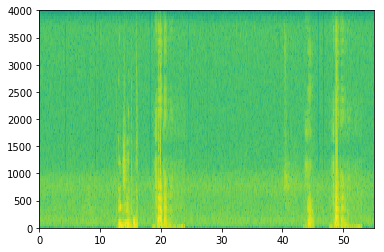

In [33]:
x2,y2,back=create_training_example(backgrounds[1], positives, negatives)
np.transpose(x2).shape
print(x2.shape)
print(y2.shape)

In [34]:
np.set_printoptions(threshold=np.inf)

In [35]:

#print(y2[0][610:])
#play(z2)
#print(p2)

# the task here onwards is to verify that the labels are correct and then we can start building the model.

# all the labels are correct, now lets build a dataset

In [36]:
#x_training=[]
#y_training=[]
#audio_training=[]
#for i in range(5):
#    x,y,z=create_training_example(backgrounds[1], positives, negatives)
#    x_training.append(np.transpose(x))
#    y_training.append(np.transpose(y))
  #  audio_training.append(z)
#np.save("x_training.npy",x_training)
#np.save("y_training.npy",y_training)

In [37]:
#play(audio_training[255])


In [38]:
#audio_training[0].export("op.wav",format="wav")

In [39]:
#rate,audio=get_wav_info("op.wav")
#print(rate)

In [40]:
#play(audio_training[98])

In [41]:
x_train=np.load("x_training.npy")
y_train=np.load("y_training.npy")

In [42]:
print(x_train[0].shape)
print(y_train[0].shape)


(5511, 101)
(1375, 1)


# model building

In [43]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model,load_model,Sequential
from keras.layers import Dense,Activation,Dropout,Input,Masking,TimeDistributed,LSTM,Conv1D
from keras.layers import GRU,Bidirectional,BatchNormalization,Reshape
from keras.optimizers import Adam
def model(input_shape):
    X_input=Input(shape=input_shape)
    X=Conv1D(196,kernel_size=15,strides=4)(X_input)
    X = BatchNormalization()(X)      
    X = Activation('relu')(X) 
    X = Dropout(0.8)(X)  
    # Step 2: First GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X) # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)     # Batch normalization
    # Step 3: Second GRU Layer (≈4 lines)
    X = GRU(units = 128, return_sequences = True)(X)   # GRU (use 128 units and return the sequences)
    X = Dropout(0.8)(X)                                 # dropout (use 0.8)
    X = BatchNormalization()(X)                                  # Batch normalization
    X = Dropout(0.8)(X)                                  # dropout (use 0.8)
   
    # Step 4: Time-distributed dense layer (≈1 line)
    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
    model = Model(inputs = X_input, outputs = X)
    return model

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [44]:
model = model(input_shape = (5511, 101))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_1 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_1 (GRU)          

In [45]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [46]:
model.fit(x_train, y_train, batch_size = 5, epochs=1000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
5/5 [==============================] - 11s 2s/step - loss: 0.8807 - acc: 0.4684
Epoch 2/1000
5/5 [==============================] - 5s 1s/step - loss: 0.8562 - acc: 0.4724
Epoch 3/1000
5/5 [==============================] - 5s 990ms/step - loss: 0.8441 - acc: 0.4854
Epoch 4/1000
5/5 [==============================] - 5s 1s/step - loss: 0.8615 - acc: 0.4461
Epoch 5/1000
5/5 [==============================] - 5s 1s/step - loss: 0.8621 - acc: 0.5225
Epoch 6/1000
5/5 [==============================] - 6s 1s/step - loss: 0.8411 - acc: 0.4592
Epoch 7/1000
5/5 [==============================] - 5s 1s/step - loss: 0.8277 - acc: 0.4801
Epoch 8/1000
5/5 [==============================] - 5s 958ms/step - loss: 0.8497 - acc: 0.4988
Epoch 9/1000
5/5 [==============================] - 5s 1s/step - loss: 0.8277 - acc: 0.4867
Epoch 10/1000
5/5 [==============================] - 5s 1s/step - loss: 0.8360 - acc: 0.5075
Epoch 11/1000
5/5 [=====

5/5 [==============================] - 5s 1s/step - loss: 0.7368 - acc: 0.8257
Epoch 86/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7311 - acc: 0.7955
Epoch 87/1000
5/5 [==============================] - 5s 1s/step - loss: 0.7549 - acc: 0.8157
Epoch 88/1000
5/5 [==============================] - 6s 1s/step - loss: 0.7450 - acc: 0.8089
Epoch 89/1000
5/5 [==============================] - 5s 987ms/step - loss: 0.7529 - acc: 0.8372
Epoch 90/1000
5/5 [==============================] - 5s 1s/step - loss: 0.7271 - acc: 0.8540
Epoch 91/1000
5/5 [==============================] - 5s 980ms/step - loss: 0.7363 - acc: 0.8154
Epoch 92/1000
5/5 [==============================] - 5s 945ms/step - loss: 0.7428 - acc: 0.7594
Epoch 93/1000
5/5 [==============================] - 5s 1s/step - loss: 0.7462 - acc: 0.8058
Epoch 94/1000
5/5 [==============================] - 5s 915ms/step - loss: 0.7415 - acc: 0.7977
Epoch 95/1000
5/5 [==============================] - 5s 1s/step - loss: 

Epoch 171/1000
5/5 [==============================] - 5s 934ms/step - loss: 0.6921 - acc: 0.8867
Epoch 172/1000
5/5 [==============================] - 5s 993ms/step - loss: 0.6949 - acc: 0.8758
Epoch 173/1000
5/5 [==============================] - 5s 930ms/step - loss: 0.7128 - acc: 0.8758
Epoch 174/1000
5/5 [==============================] - 5s 909ms/step - loss: 0.6815 - acc: 0.8947
Epoch 175/1000
5/5 [==============================] - 5s 994ms/step - loss: 0.6967 - acc: 0.8883
Epoch 176/1000
5/5 [==============================] - 5s 924ms/step - loss: 0.7081 - acc: 0.8927
Epoch 177/1000
5/5 [==============================] - 5s 1s/step - loss: 0.7110 - acc: 0.8877
Epoch 178/1000
5/5 [==============================] - 5s 949ms/step - loss: 0.7106 - acc: 0.8851
Epoch 179/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6936 - acc: 0.8992
Epoch 180/1000
5/5 [==============================] - 5s 939ms/step - loss: 0.6961 - acc: 0.8828
Epoch 181/1000
5/5 [================

Epoch 258/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6664 - acc: 0.9151
Epoch 259/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6780 - acc: 0.9199
Epoch 260/1000
5/5 [==============================] - 7s 1s/step - loss: 0.6874 - acc: 0.9126
Epoch 261/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6595 - acc: 0.9153
Epoch 262/1000
5/5 [==============================] - 7s 1s/step - loss: 0.6741 - acc: 0.9235
Epoch 263/1000
5/5 [==============================] - 6s 1s/step - loss: 0.6811 - acc: 0.9123
Epoch 264/1000
5/5 [==============================] - 7s 1s/step - loss: 0.6567 - acc: 0.9248
Epoch 265/1000
5/5 [==============================] - 7s 1s/step - loss: 0.6787 - acc: 0.9148
Epoch 266/1000
5/5 [==============================] - 7s 1s/step - loss: 0.6647 - acc: 0.9085
Epoch 267/1000
5/5 [==============================] - 7s 1s/step - loss: 0.6526 - acc: 0.9225
Epoch 268/1000
5/5 [==============================] - 6s 1s/

5/5 [==============================] - 9s 2s/step - loss: 0.6619 - acc: 0.9284
Epoch 346/1000
5/5 [==============================] - 9s 2s/step - loss: 0.6462 - acc: 0.9279
Epoch 347/1000
5/5 [==============================] - 8s 2s/step - loss: 0.6467 - acc: 0.9274
Epoch 348/1000
5/5 [==============================] - 9s 2s/step - loss: 0.6397 - acc: 0.9281
Epoch 349/1000
5/5 [==============================] - 8s 2s/step - loss: 0.6366 - acc: 0.9341
Epoch 350/1000
5/5 [==============================] - 9s 2s/step - loss: 0.6437 - acc: 0.9316
Epoch 351/1000
5/5 [==============================] - 9s 2s/step - loss: 0.6446 - acc: 0.9325
Epoch 352/1000
5/5 [==============================] - 9s 2s/step - loss: 0.6380 - acc: 0.9321
Epoch 353/1000
5/5 [==============================] - 10s 2s/step - loss: 0.6300 - acc: 0.9335
Epoch 354/1000
5/5 [==============================] - 8s 2s/step - loss: 0.6468 - acc: 0.9324
Epoch 355/1000
5/5 [==============================] - 9s 2s/step - loss: 0

5/5 [==============================] - 5s 986ms/step - loss: 0.6363 - acc: 0.9363
Epoch 432/1000
5/5 [==============================] - 5s 973ms/step - loss: 0.6142 - acc: 0.9382
Epoch 433/1000
5/5 [==============================] - 5s 928ms/step - loss: 0.6368 - acc: 0.9347
Epoch 434/1000
5/5 [==============================] - 5s 995ms/step - loss: 0.6301 - acc: 0.9354
Epoch 435/1000
5/5 [==============================] - 5s 936ms/step - loss: 0.6270 - acc: 0.9363
Epoch 436/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6225 - acc: 0.9338
Epoch 437/1000
5/5 [==============================] - 5s 947ms/step - loss: 0.6171 - acc: 0.9327
Epoch 438/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6285 - acc: 0.9341
Epoch 439/1000
5/5 [==============================] - 5s 920ms/step - loss: 0.6233 - acc: 0.9354
Epoch 440/1000
5/5 [==============================] - 5s 947ms/step - loss: 0.6347 - acc: 0.9380
Epoch 441/1000
5/5 [==============================]

5/5 [==============================] - 5s 1s/step - loss: 0.6217 - acc: 0.9372
Epoch 517/1000
5/5 [==============================] - 5s 940ms/step - loss: 0.6221 - acc: 0.9369
Epoch 518/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6282 - acc: 0.9334
Epoch 519/1000
5/5 [==============================] - 5s 939ms/step - loss: 0.6097 - acc: 0.9372
Epoch 520/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6227 - acc: 0.9367
Epoch 521/1000
5/5 [==============================] - 5s 918ms/step - loss: 0.6189 - acc: 0.9373
Epoch 522/1000
5/5 [==============================] - 5s 928ms/step - loss: 0.6149 - acc: 0.9372
Epoch 523/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6084 - acc: 0.9404
Epoch 524/1000
5/5 [==============================] - 5s 991ms/step - loss: 0.6041 - acc: 0.9399
Epoch 525/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6226 - acc: 0.9377
Epoch 526/1000
5/5 [==============================] - 5s 1s/

Epoch 603/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5920 - acc: 0.9398
Epoch 604/1000
5/5 [==============================] - 5s 976ms/step - loss: 0.5955 - acc: 0.9431
Epoch 605/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5936 - acc: 0.9391
Epoch 606/1000
5/5 [==============================] - 5s 962ms/step - loss: 0.6048 - acc: 0.9408
Epoch 607/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6039 - acc: 0.9392
Epoch 608/1000
5/5 [==============================] - 5s 965ms/step - loss: 0.6075 - acc: 0.9399
Epoch 609/1000
5/5 [==============================] - 5s 979ms/step - loss: 0.6010 - acc: 0.9402
Epoch 610/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6226 - acc: 0.9337
Epoch 611/1000
5/5 [==============================] - 5s 994ms/step - loss: 0.6157 - acc: 0.9380
Epoch 612/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6073 - acc: 0.9393
Epoch 613/1000
5/5 [=========================

Epoch 690/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5885 - acc: 0.9408
Epoch 691/1000
5/5 [==============================] - 5s 952ms/step - loss: 0.5972 - acc: 0.9407
Epoch 692/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5976 - acc: 0.9401
Epoch 693/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5818 - acc: 0.9383
Epoch 694/1000
5/5 [==============================] - 5s 1s/step - loss: 0.6025 - acc: 0.9411
Epoch 695/1000
5/5 [==============================] - 5s 952ms/step - loss: 0.5950 - acc: 0.9417
Epoch 696/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5867 - acc: 0.9407
Epoch 697/1000
5/5 [==============================] - 5s 945ms/step - loss: 0.5858 - acc: 0.9408
Epoch 698/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5846 - acc: 0.9423
Epoch 699/1000
5/5 [==============================] - 5s 997ms/step - loss: 0.5758 - acc: 0.9441
Epoch 700/1000
5/5 [============================

Epoch 776/1000
5/5 [==============================] - 5s 987ms/step - loss: 0.6013 - acc: 0.9414
Epoch 777/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5847 - acc: 0.9433
Epoch 778/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5848 - acc: 0.9398
Epoch 779/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5960 - acc: 0.9407
Epoch 780/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5971 - acc: 0.9415
Epoch 781/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5891 - acc: 0.9391
Epoch 782/1000
5/5 [==============================] - 5s 983ms/step - loss: 0.5810 - acc: 0.9440
Epoch 783/1000
5/5 [==============================] - 6s 1s/step - loss: 0.5818 - acc: 0.9407
Epoch 784/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5755 - acc: 0.9418
Epoch 785/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5981 - acc: 0.9418
Epoch 786/1000
5/5 [==============================] - 

5/5 [==============================] - 5s 919ms/step - loss: 0.5880 - acc: 0.9415
Epoch 863/1000
5/5 [==============================] - 5s 990ms/step - loss: 0.5551 - acc: 0.9436
Epoch 864/1000
5/5 [==============================] - 5s 914ms/step - loss: 0.5738 - acc: 0.9460
Epoch 865/1000
5/5 [==============================] - 5s 911ms/step - loss: 0.5827 - acc: 0.9431
Epoch 866/1000
5/5 [==============================] - 5s 980ms/step - loss: 0.5783 - acc: 0.9411
Epoch 867/1000
5/5 [==============================] - 5s 927ms/step - loss: 0.5722 - acc: 0.9447
Epoch 868/1000
5/5 [==============================] - 5s 1s/step - loss: 0.5738 - acc: 0.9418
Epoch 869/1000
5/5 [==============================] - 5s 931ms/step - loss: 0.5837 - acc: 0.9420
Epoch 870/1000
5/5 [==============================] - 5s 997ms/step - loss: 0.5701 - acc: 0.9425
Epoch 871/1000
5/5 [==============================] - 5s 920ms/step - loss: 0.5825 - acc: 0.9424
Epoch 872/1000
5/5 [============================

5/5 [==============================] - 5s 969ms/step - loss: 0.5796 - acc: 0.9427
Epoch 948/1000
5/5 [==============================] - 5s 975ms/step - loss: 0.5583 - acc: 0.9455
Epoch 949/1000
5/5 [==============================] - 5s 930ms/step - loss: 0.5709 - acc: 0.9431
Epoch 950/1000
5/5 [==============================] - 5s 997ms/step - loss: 0.5715 - acc: 0.9439
Epoch 951/1000
5/5 [==============================] - 5s 932ms/step - loss: 0.5623 - acc: 0.9450
Epoch 952/1000
5/5 [==============================] - 5s 995ms/step - loss: 0.5622 - acc: 0.9446
Epoch 953/1000
5/5 [==============================] - 5s 914ms/step - loss: 0.5624 - acc: 0.9453
Epoch 954/1000
5/5 [==============================] - 5s 936ms/step - loss: 0.5777 - acc: 0.9431
Epoch 955/1000
5/5 [==============================] - 5s 996ms/step - loss: 0.5621 - acc: 0.9440
Epoch 956/1000
5/5 [==============================] - 5s 922ms/step - loss: 0.5573 - acc: 0.9431
Epoch 957/1000
5/5 [=========================

# first training - 100 examples 100 epochs 0.8506 accuracy loss - 0.5591930794715881 most predictions were having probability of 0.39...
# second training- 1000 examples 1000 epochs 

# Evaluate the model

In [47]:
loss, acc = model.evaluate(x_train, y_train)
print("Dev set accuracy = ", acc,loss)

5/5 [==============================] - 2s 318ms/step
Dev set accuracy =  0.9458909034729004 0.5650323033332825


# Making predictions

In [54]:
def detect_triggerword(i):
    #plt.subplot(2, 1, 1)

    #x,y,z = graph_spectrogram(filename)
    
    #x  = x.swapaxes(0,1)
    x=x_train[i]
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
   # plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

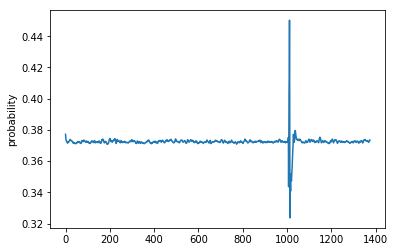

array([[[0.37715948],
        [0.37496638],
        [0.37381577],
        [0.37309074],
        [0.37308955],
        [0.37268403],
        [0.3722142 ],
        [0.37216687],
        [0.37180614],
        [0.37150276],
        [0.37188286],
        [0.37216026],
        [0.3721714 ],
        [0.3720047 ],
        [0.37224644],
        [0.37241593],
        [0.37261766],
        [0.37304276],
        [0.37314445],
        [0.37338296],
        [0.37384292],
        [0.3738704 ],
        [0.37384248],
        [0.37354356],
        [0.3733285 ],
        [0.3731954 ],
        [0.37287375],
        [0.37292385],
        [0.3729148 ],
        [0.37290034],
        [0.372749  ],
        [0.3725866 ],
        [0.37246832],
        [0.37179235],
        [0.37195837],
        [0.37191042],
        [0.3715615 ],
        [0.3716448 ],
        [0.37177235],
        [0.37153864],
        [0.37165606],
        [0.3713088 ],
        [0.3712982 ],
        [0.37135386],
        [0.37128052],
        [0

In [55]:
detect_triggerword(4)

In [51]:
print (x.shape,y.shape,z.shape)

NameError: name 'x' is not defined

In [57]:
model.save("smu.HDf5")